In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import re
from IPython.display import display, HTML

In [2]:
SHOW_FIGURES = True

In [3]:
if not SHOW_FIGURES:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })


In [4]:
file_paths = ['./results/results.csv', #power2
              './results/results_power2_2.csv',
              './results/results_power1_1.csv',
             ]

In [5]:
csv_dict = []
def load_file(file_path, csv_dict):
    with open(file_path, 'r') as file:
        # Iterate over each line in the fileplt.plot(x_fit, y_fit, color='green', label='Polynomial Approximation')
        for line in file:
            # Split the line content by comma
            line_data = line.strip().split(',')
    
            if len(line_data) == 7:
                seven_keys = ['delta', 'state', 'time', 'occupation', 'fairness', 'allocated', 'skipped']
                csv_dict.append(dict(zip(seven_keys, line_data)))
    
            elif len(line_data) == 15:
                fifteen_keys = ['method', 'execution time', 'delta', 'average make span', 'result message',
                                'makespan', 'resource occupation', 'resource fairness',
                                'assigned tasks', 'allocated tasks', 'postponed tasks',
                                'optimal solution', 'feasible solution', 'no solution',
                                'resource worklist rule'
                                ]
                csv_dict.append(dict(zip(fifteen_keys, line_data)))
            elif len(line_data) == 19:
                nineteen_keys = ['method', 'start time', 'end time', 'real execution time', 'system execution time',
                                 'delta', 'average make span', 'result message',
                                'makespan', 'resource occupation', 'resource fairness', 'weighted resource fairness',
                                'assigned tasks', 'allocated tasks', 'postponed tasks',
                                'optimal solution', 'feasible solution', 'no solution',
                                'resource worklist rule'
                                ]
                row_dict = dict(zip(nineteen_keys, line_data))
                for k in ['optimal solution', 'feasible solution', 'no solution']:
                    if row_dict[k] == '':
                        row_dict[k] = 0
                csv_dict.append(row_dict)
            else:
                print(len(line_data))

df_dtypes = {'method' : str, 'start time' : str, 'end time' : str, 'real execution time' : float, 'system execution time' : float,
             'delta' : float, 'makespan' : float, 'result message' : str,
             'makespan' : float, 'resource occupation' : float, 'resource fairness' : float, 'weighted resource fairness' : float,
             'assigned tasks' : int, 'allocated tasks' : int, 'postponed tasks' : int,
             'optimal solution' : int, 'feasible solution' : int, 'no solution' : int,
             'resource worklist rule' : str}

for f in file_paths:
    load_file(f, csv_dict)
df = pd.DataFrame(csv_dict)
for k, v in df_dtypes.items():
    df[k] = df[k].astype(v)

In [6]:
df = df[df['method'] == 'MILP']
df.reset_index(inplace=True)

In [7]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
display(HTML(df.sort_values('delta').to_html()))

,index,method,start time,end time,real execution time,system execution time,delta,average make span,result message,makespan,resource occupation,resource fairness,weighted resource fairness,assigned tasks,allocated tasks,postponed tasks,optimal solution,feasible solution,no solution,resource worklist rule
1,117,MILP,2024-06-04 17:49:00,2024-06-04 22:57:08,18488.147444,142748.801314,1.0,1039.2525416437877,COMPLETED: you completed 8760 hours of simulated customer cases. 1640 cases started. 1314 cases run to completion.,1296.829123,0.605511,0.042139,67.492604,19951,138397,129803,14581,4821,0,EIF
21,137,MILP,2024-06-04 22:22:01,2024-06-05 05:46:26,26664.594940,209448.836374,1.0,564.4103081677105,COMPLETED: you completed 8760 hours of simulated customer cases. 1602 cases started. 1376 cases run to completion.,657.114211,0.606823,0.039188,64.826959,21111,143305,114312,10641,10032,0,fastest
22,138,MILP,2024-06-04 22:22:01,2024-06-05 06:14:25,28344.006404,223075.492509,1.1,663.9488789694574,COMPLETED: you completed 8760 hours of simulated customer cases. 1538 cases started. 1312 cases run to completion.,778.455136,0.588528,0.041508,68.310345,20733,140716,103139,10043,10149,0,fastest
2,118,MILP,2024-06-04 17:49:00,2024-06-04 23:05:09,18968.716745,157285.310307,1.1,934.2129526614378,COMPLETED: you completed 8760 hours of simulated customer cases. 1686 cases started. 1331 cases run to completion.,1183.478651,0.582439,0.037210,64.483760,20345,138723,178586,14126,5745,0,EIF
3,119,MILP,2024-06-04 17:49:00,2024-06-04 23:07:23,19102.714046,155931.078795,1.2,1032.2591926093464,COMPLETED: you completed 8760 hours of simulated customer cases. 1615 cases started. 1343 cases run to completion.,1241.411673,0.614380,0.041449,68.696074,20424,141625,208469,14106,5694,0,EIF
20,136,MILP,2024-06-04 22:22:01,2024-06-05 04:46:32,23070.365211,177806.604845,1.3,473.122569057926,COMPLETED: you completed 8760 hours of simulated customer cases. 1502 cases started. 1352 cases run to completion.,525.624143,0.604749,0.040171,66.287465,20487,137673,62841,12993,6965,0,fastest
0,116,MILP,2024-06-04 17:49:00,2024-06-04 22:18:30,16170.504039,124190.040637,1.3,901.8963973308471,COMPLETED: you completed 8760 hours of simulated customer cases. 1623 cases started. 1268 cases run to completion.,1153.851981,0.598537,0.039665,64.475718,19604,129919,134002,14778,4361,0,EIF
5,121,MILP,2024-06-04 22:18:31,2024-06-05 02:15:59,14247.858670,112666.488631,1.4,884.0118581169125,COMPLETED: you completed 8760 hours of simulated customer cases. 1607 cases started. 1289 cases run to completion.,1102.200071,0.622981,0.043753,71.065368,19510,131691,134360,15246,3591,0,EIF
23,139,MILP,2024-06-05 04:35:59,2024-06-05 08:46:32,15033.030792,113362.672967,1.4,326.95786833942674,COMPLETED: you completed 8760 hours of simulated customer cases. 1515 cases started. 1364 cases run to completion.,363.066897,0.631563,0.042343,67.002107,20360,130179,55061,16336,3462,0,fastest
4,120,MILP,2024-06-04 22:57:09,2024-06-05 01:41:06,9836.895432,74995.365227,1.5,585.2084009591775,COMPLETED: you completed 8760 hours of simulated customer cases. 1578 cases started. 1276 cases run to completion.,723.826218,0.624119,0.042831,68.948766,19580,128206,61595,16725,2269,0,EIF


In [8]:
df[df['resource worklist rule'] == 'slowest']

,index,method,start time,end time,real execution time,system execution time,delta,average make span,result message,makespan,resource occupation,resource fairness,weighted resource fairness,assigned tasks,allocated tasks,postponed tasks,optimal solution,feasible solution,no solution,resource worklist rule
17,133,MILP,2024-06-04 13:27:17,2024-06-04 19:13:59,20802.742272,150302.215364,3.0,1659.5488070676865,COMPLETED: you completed 8760 hours of simulat...,3148.716214,0.614439,0.064699,108.128271,14639,101429,41683,5938,7871,237,slowest
18,134,MILP,2024-06-04 13:27:17,2024-06-04 20:08:11,24053.851056,165095.062324,4.0,2387.122863335978,COMPLETED: you completed 8760 hours of simulat...,5518.128409,0.605152,0.073036,119.987042,13001,89902,76122,3273,8452,635,slowest
19,135,MILP,2024-06-04 13:27:17,2024-06-04 20:29:24,25326.865384,208556.522348,2.0,1342.6704237769711,COMPLETED: you completed 8760 hours of simulat...,1902.497797,0.632993,0.053426,86.724382,17202,122478,93141,6046,10485,6,slowest


In [9]:
for i in df.index:
    result_message = df['result message'].iloc[i]
    
    # Find all digits enclosed in word boundaries
    matches = re.findall(r"\b(\d+)\b", result_message)
    if len(matches) == 3:
        df.loc[i, 'hours'] = int(matches[0])
        df.loc[i, 'cases started'] = int(matches[1])
        df.loc[i, 'cases completed'] = int(matches[2])
    else:
        print(i)

In [10]:
df = df[df['average make span'] != 'Stopped']
print(len(df))

27


In [11]:
# When two equal delta values are present sample a random one
result = df.groupby(['resource worklist rule', 'delta']).apply(lambda x: x.sample(1)).reset_index(drop=True)
#result
df = result
print(len(df))

27


/tmp/ipykernel_39397/3009690001.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['resource worklist rule', 'delta']).apply(lambda x: x.sample(1)).reset_index(drop=True)


In [12]:
from scipy.optimize import curve_fit

def polynomial_func(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

degree = 1 # Adjust the degree of the polynomial
params = lambda df, y_value, degree: curve_fit(polynomial_func, df['delta'], df[y_value], p0=[1] * (degree + 1))[0]



In [13]:
df = df[df['result message'] != 'Stopped']
df = df.sort_values(by='delta')

fastest_df = df[df['resource worklist rule'] == 'fastest']
random_df = df[df['resource worklist rule'] == 'random']

slowest_df = df[df['resource worklist rule'] == 'slowest']
eif_df = df[df['resource worklist rule'] == 'EIF']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

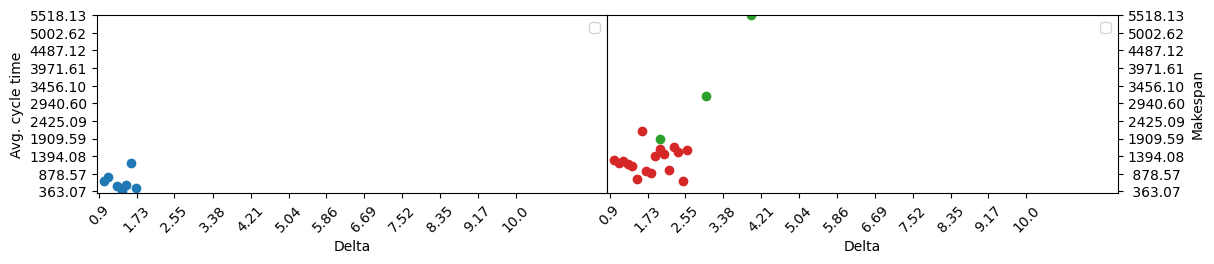

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

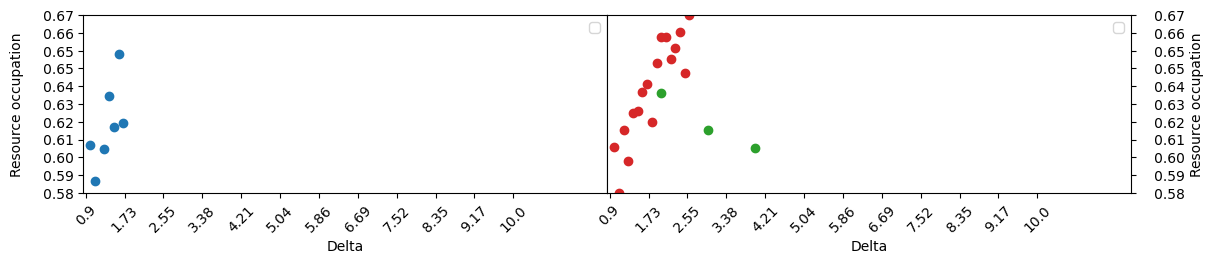

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

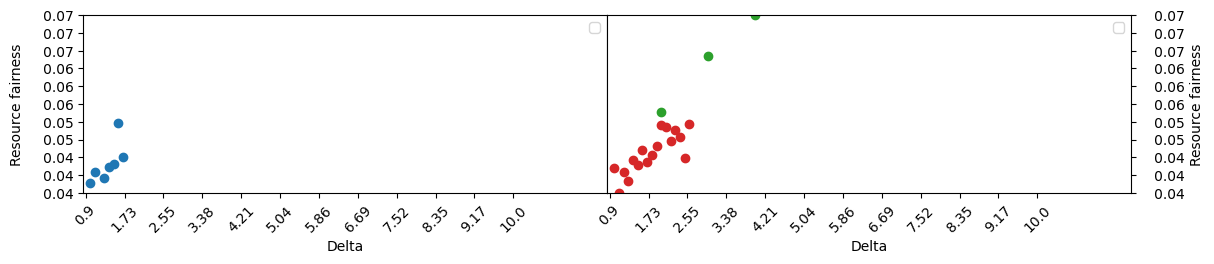

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

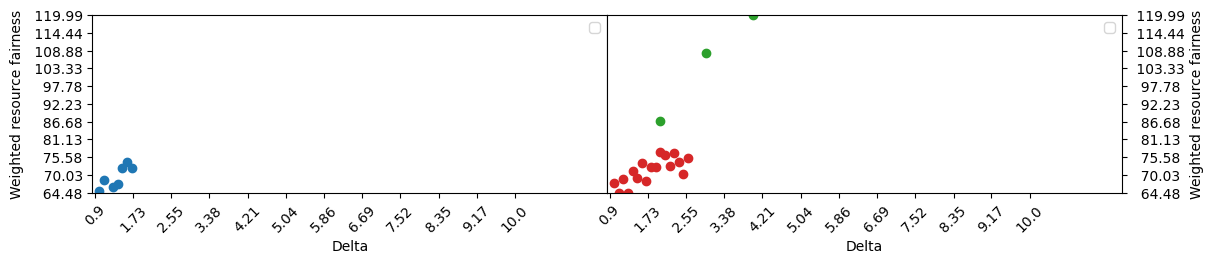

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

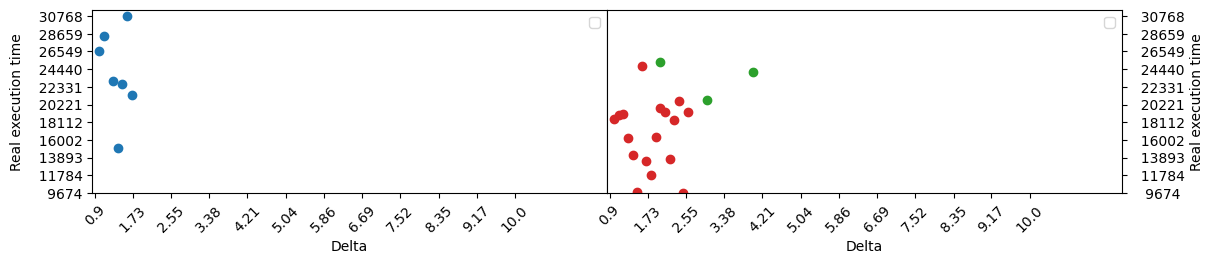

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

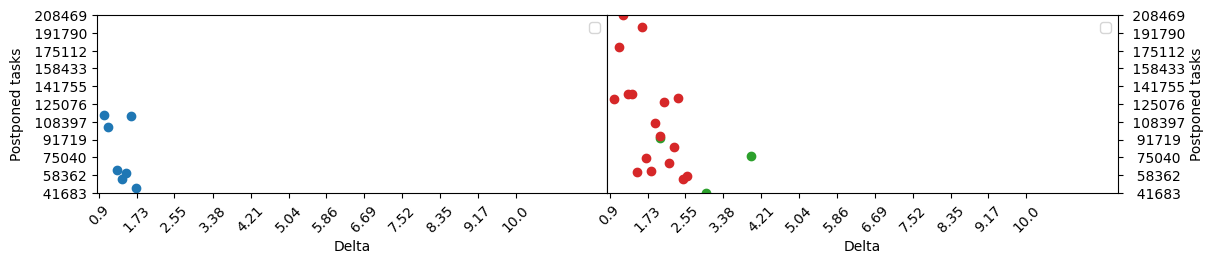

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

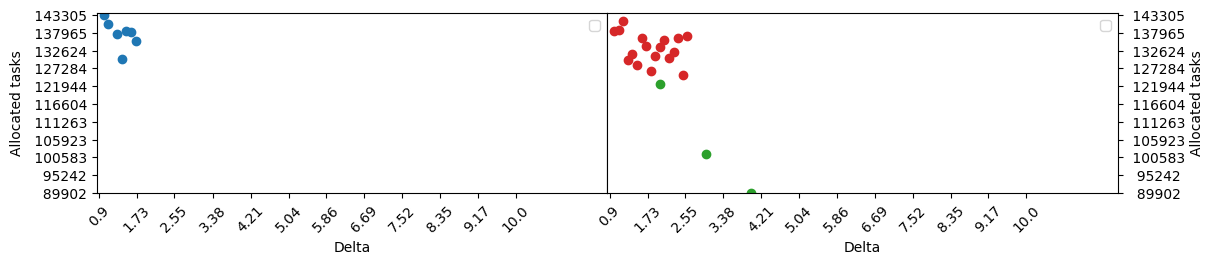

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

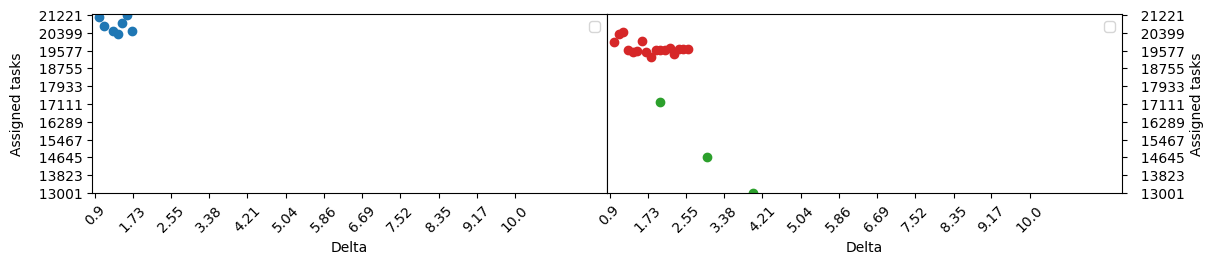

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

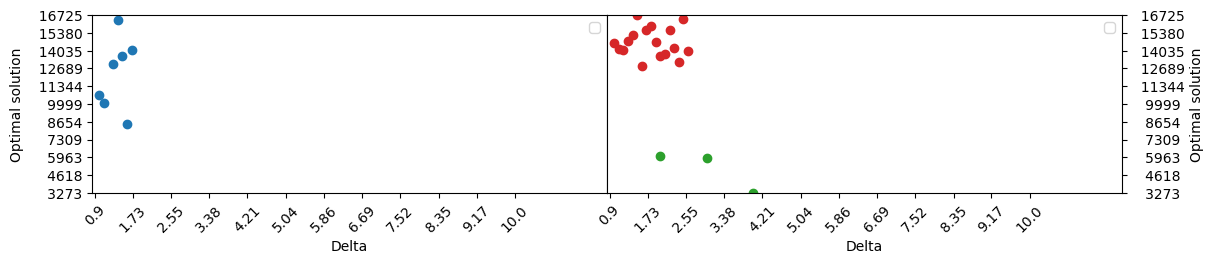

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

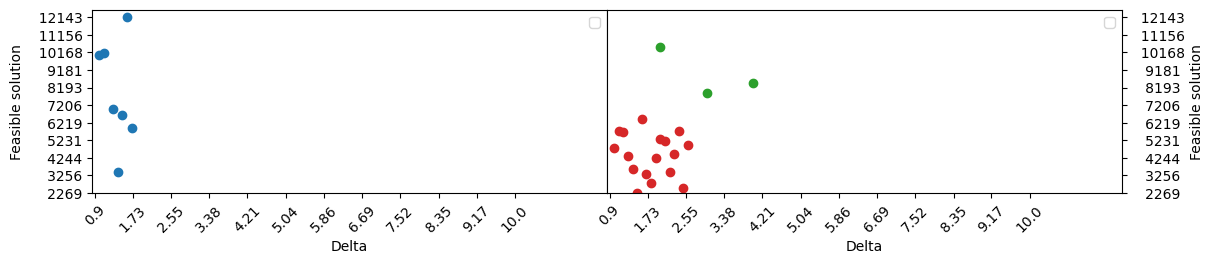

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

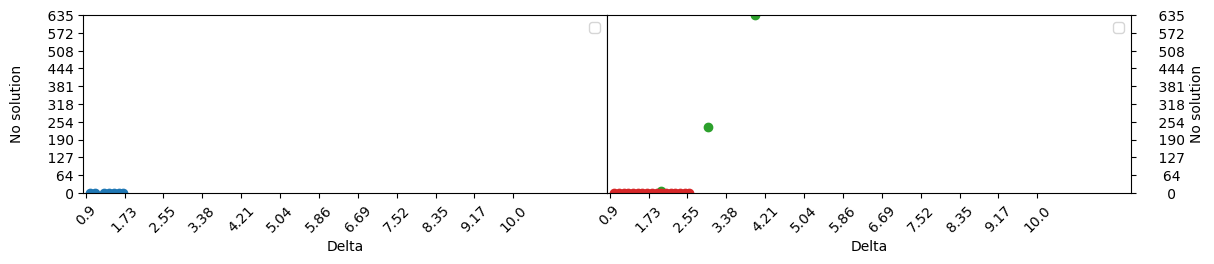

In [14]:

def four_plot_1(x_value, y_value, degree=1, format="{x:.2f}", yrange=None, labels=None):
    plt.clf()
    
    # Plot the data
    fig, ax = plt.subplots(1,2, figsize=(12,2.5))
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # fastest
    delta_values = fastest_df[x_value]
    time_values = fastest_df[y_value]
    p = ax[0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(fastest_df[x_value].min(), fastest_df[x_value].max(), 100)
    #y_fit = polynomial_func(x_fit, *params(fastest_df, y_value, degree))
    #ax[0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Shortest: ' + y_value)
    
    # random
    delta_values = random_df[x_value]
    time_values = random_df[y_value]
    p = ax[0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    #y_fit = polynomial_func(x_fit, *params(random_df, y_value, degree))
    #ax[0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Random: ' + y_value)

    if labels:
        ax[0].set_xlabel(labels[0])
        ax[0].set_ylabel(labels[1])
    else:
        ax[0].set_xlabel(x_value.capitalize())
        ax[0].set_ylabel(y_value.capitalize())
    #ax[0].set_xticks([round(i,2) for i in np.linspace(0.9, 2.0, 12)])
    #ax[0].set_xlim(0.85, 2.05)
    ax[0].set_xticks([round(i,2) for i in np.linspace(0.9, 10.0, 12)])
    ax[0].set_xlim(0.85, 12)
    ax[0].set_xticklabels(ax[0].get_xticks(), rotation=45)
    #ax[0].set_yticklabels(ax[0].get_yticks(), rotation=45)
    if yrange:
        ax[0].set_ylim(*yrange)
        ax[0].set_yticks(np.linspace(yrange[0], yrange[1], 11))
    else:
        ax[0].set_yticks(np.linspace(df[y_value].min(), df[y_value].max(), 11))
    ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter(format))
    ax[0].legend()
    
    # second figure
    # slowest
    delta_values = slowest_df[x_value]
    time_values = slowest_df[y_value]
    p = ax[1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    #y_fit = polynomial_func(x_fit, *params(slowest_df, y_value, degree))
    #ax[1].plot(x_fit, y_fit, color=p.get_facecolor(), label='Slowest: ' + y_value)
    
    # EIF
    delta_values = eif_df[x_value]
    time_values = eif_df[y_value]
    p = ax[1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    #y_fit = polynomial_func(x_fit, *params(eif_df, y_value, degree))
    #ax[1].plot(x_fit, y_fit, color=p.get_facecolor(), label='EIF: ' + y_value)
    
    ax[1].set_xlabel(x_value.capitalize())
    ax[1].set_ylabel(y_value.capitalize())
    ax[1].set_yticks(ax[0].get_yticks())
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")
    ax[1].set_xticks(ax[0].get_xticks())
    ax[1].set_xticklabels(ax[0].get_xticks(), rotation=45)
    #ax[1].set_yticklabels(ax[0].get_yticks(), rotation=45)
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].yaxis.set_major_formatter(ticker.StrMethodFormatter(format))
    ax[1].legend()
    
    
    # Set labels and title
    #plt.suptitle(x_value + '/' + y_value)
    
    #plt.xticks(rotation=45)
    # Show the plot
    #plt.show()
    plt.tight_layout(pad=0.2)
    plt.subplots_adjust(wspace=0, hspace=0)
    if SHOW_FIGURES:
        plt.show()
    else:
        plt.savefig(y_value + '.pgf')

four_plot_1('delta', 'makespan', labels=('Delta', 'Avg. cycle time'), format="{x:7.2f}")
four_plot_1('delta', 'resource occupation', format="{x:7.2f}", degree=3)
four_plot_1('delta', 'resource fairness', format="{x:7.2f}", degree=3)
four_plot_1('delta', 'weighted resource fairness', format="{x:7.2f}", degree=3)

four_plot_1('delta', 'real execution time', format="{x:7.0f}")
four_plot_1('delta', 'postponed tasks', format="{x:7.0f}")
four_plot_1('delta', 'allocated tasks', format="{x:7.0f}")
four_plot_1('delta', 'assigned tasks', format="{x:7.0f}")


four_plot_1('delta', 'optimal solution', format="{x:7.0f}")
four_plot_1('delta', 'feasible solution', format="{x:7.0f}")

four_plot_1('delta', 'no solution', format="{x:7.0f}")


/tmp/ipykernel_39397/2443308346.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  params = lambda df, y_value, degree: curve_fit(polynomial_func, df['delta'], df[y_value], p0=[1] * (degree + 1))[0]


ValueError: `ydata` must not be empty!

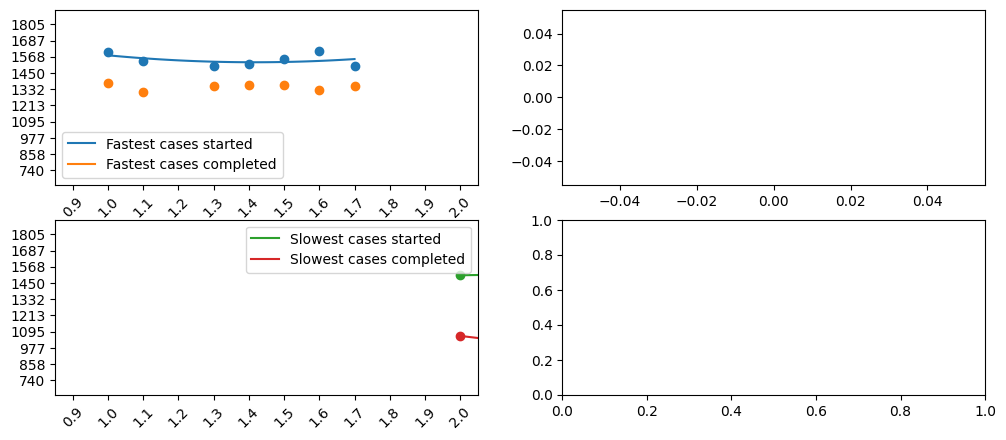

In [15]:

# Plot the data

def four_plot_2(x_value, y_value_1, y_value_2, degree=2):
    fig, ax = plt.subplots(2,2, figsize=(12,5))
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # First figure: Fastest
    # started
    delta_values = fastest_df[x_value]
    time_values = fastest_df[y_value_1]
    p = ax[0, 0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(fastest_df[x_value].min(), fastest_df[x_value].max(), 100)
    y_fit = polynomial_func(x_fit, *params(fastest_df, y_value_1, degree))
    ax[0, 0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Fastest ' + y_value_1)
    
    # completed
    delta_values = fastest_df[x_value]
    time_values = fastest_df[y_value_2]
    p = ax[0, 0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(random_df[x_value].min(), random_df[x_value].max(), 100)
    y_fit = polynomial_func(x_fit, *params(fastest_df, y_value_2, degree))
    ax[0, 0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Fastest ' + y_value_2)
    
    #ax[0, 0].set_xlabel(x_value)
    #ax[0, 0].set_ylabel(y_value_1 + '/' + y_value_2)
    ax[0, 0].set_yticks(np.linspace(df[[y_value_1, y_value_2]].min().min(), df[[y_value_1, y_value_2]].max().max(), 10))
    t = [round(i, 2) for i in np.linspace(0.9, 2.0, 12)]
    ax[0, 0].set_xticks(t)
    ax[0, 0].set_xticklabels(ax[0, 0].get_xticks(), rotation=45)
    ax[0, 0].set_xlim(0.85, 2.05)
    y_range = df[[y_value_1, y_value_2]].max().max() - df[[y_value_1, y_value_2]].min().min()
    ax[0, 0].set_ylim(df[[y_value_1, y_value_2]].min().min() - y_range*0.1,
                      df[[y_value_1, y_value_2]].max().max() + y_range*0.1)
    ax[0, 0].legend()
    
    
    # Second figure: Slowest
    # Started
    delta_values = slowest_df[x_value]
    time_values = slowest_df[y_value_1]
    p = ax[1, 0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(slowest_df, y_value_1, degree))
    ax[1, 0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Slowest ' + y_value_1)
    
    # Completed
    delta_values = slowest_df[x_value]
    time_values = slowest_df[y_value_2]
    p = ax[1, 0].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(slowest_df, y_value_2, degree))
    ax[1, 0].plot(x_fit, y_fit, color=p.get_facecolor(), label='Slowest ' + y_value_2)
    
    #ax[1, 0].set_xlabel(x_value)
    #ax[1, 0].set_ylabel(y_value_1 + '/' + y_value_2)
    ax[1, 0].set_yticks(ax[0, 0].get_yticks())
    ax[1, 0].set_ylim(ax[0, 0].get_ylim())
    ax[1, 0].yaxis.tick_left()
    ax[1, 0].yaxis.set_label_position("left")
    ax[1, 0].set_xticks(ax[0, 0].get_xticks())
    ax[1, 0].set_xticklabels(ax[0, 0].get_xticks(), rotation=45)
    ax[1, 0].set_xlim(ax[0, 0].get_xlim())
    ax[1, 0].legend()

    next(colors)["color"]
    
    # Third figure: Random
    # Started
    delta_values = random_df[x_value]
    time_values = random_df[y_value_1]
    p = ax[0, 1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(random_df, y_value_1, degree))
    ax[0, 1].plot(x_fit, y_fit, color=p.get_facecolor(), label='Random ' + y_value_1)
    
    # Completed
    delta_values = random_df[x_value]
    time_values = random_df[y_value_2]
    p = ax[0, 1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(random_df, y_value_2, degree))
    ax[0, 1].plot(x_fit, y_fit, color=p.get_facecolor(), label='Random ' + y_value_2)
    
    #ax[0, 1].set_xlabel(x_value)
    #ax[0, 1].set_ylabel(y_value_1 + '/' + y_value_2)
    ax[0, 1].set_yticks(ax[0, 0].get_yticks())
    ax[0, 1].set_ylim(ax[0, 0].get_ylim())
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].yaxis.set_label_position("left")
    ax[0, 1].set_xticks(ax[0, 0].get_xticks())
    ax[0, 1].set_xticklabels(ax[0, 0].get_xticks(), rotation=45)
    ax[0, 1].set_xlim(ax[0, 0].get_xlim())
    ax[0, 1].legend()

    
    # Fourth figure: EIF
    # Started
    delta_values = eif_df[x_value]
    time_values = eif_df[y_value_1]
    p = ax[1, 1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(eif_df, y_value_1, degree))
    ax[1, 1].plot(x_fit, y_fit, color=p.get_facecolor(), label='EIF ' + y_value_1)
    
    # Completed
    delta_values = eif_df[x_value]
    time_values = eif_df[y_value_2]
    p = ax[1, 1].scatter(delta_values, time_values, marker='o', color=next(colors)["color"])
    x_fit = np.linspace(delta_values.min(), delta_values.max(), 100)
    y_fit = polynomial_func(x_fit, *params(eif_df, y_value_2, degree))
    ax[1, 1].plot(x_fit, y_fit, color=p.get_facecolor(), label='EIF ' + y_value_2)
    
    #ax[1, 1].set_xlabel(x_value)
    #ax[1, 1].set_ylabel(y_value_1 + '/' + y_value_2)
    ax[1, 1].set_yticks(ax[0, 0].get_yticks())
    ax[1, 1].set_ylim(ax[0, 0].get_ylim())
    ax[1, 1].yaxis.tick_right()
    ax[1, 1].yaxis.set_label_position("right")
    ax[1, 1].set_xticks(ax[0, 0].get_xticks())
    ax[1, 1].set_xticklabels(ax[0, 0].get_xticks(), rotation=45)
    ax[1, 1].set_xlim(ax[0, 0].get_xlim())
    ax[1, 1].legend()
    
    
    
    
    # Set labels and title
    
    #plt.suptitle(x_value + ' : ' + y_value_1 + '/' + y_value_2)
    #fig.text(0.04, 0.5, y_value_1 + '/' + y_value_2, va='center', rotation='vertical')
    #plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout(pad=0.2)
    plt.subplots_adjust(wspace=0, hspace=0)
    if not SHOW_FIGURES:
        plt.savefig(y_value_1 + '_' + y_value_2 + '.pgf')
    plt.show()

four_plot_2('delta', 'cases started', 'cases completed')
four_plot_2('delta', 'postponed tasks', 'allocated tasks')
four_plot_2('delta', 'postponed tasks', 'assigned tasks')


four_plot_2('delta', 'optimal solution', 'feasible solution')
four_plot_2('delta', 'system execution time', 'real execution time')